# Setup

In [27]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [28]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BigBirdPegasusForConditionalGeneration, DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Load Pegasus fine-tuned on Arxiv

model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")

model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")



OSError: google/bigbird-pegasus-large-xsum is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [4]:
model.config

BigBirdPegasusConfig {
  "_name_or_path": "google/bigbird-pegasus-large-arxiv",
  "activation_dropout": 0.0,
  "activation_function": "gelu_new",
  "architectures": [
    "BigBirdPegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 2,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "length_penalty": 0.8,
  "max_length": 256,
  "max_position_embeddings": 4096,
  "model_type": "bigbird_pegasus",
  "num_beams": 5,
  "num_hidden_layers": 16,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "scale_embedding": true,
  "tokenizer_cla

In [5]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [6]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [7]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/arxiv_pegasus/generated/orig.txt'
greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/arxiv_pegasus/generated/greedy.csv"

In [8]:
NUM_SEQ=100
MAX_LEN = 256
MAX_SOURCE_LEN=2048
WIDTH=10

# Entropy of Human Data

In [9]:
human_dataframe = pd.read_csv(orig_wp, sep='\t', names=['context', 'model_text'])
human_dataframe['model_text'] = human_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

In [11]:
human_datapoint = human_dataframe.iloc[0]
# print(human_datapoint.context)
print()
print(print_sample(human_datapoint.context, human_datapoint.model_text))


the short - term periodicities of the daily sunspot area fluctuations from august 1923 to october 1933 are discussed . for these data 
 the correlative analysis indicates negative correlation for the periodicity of about @xmath0 days , but the power spectrum analysis indicates a statistically significant peak in this time interval . 
 a new method of the diagnosis of an echo - effect in spectrum is proposed and it is stated that the 155-day periodicity is a harmonic of the periodicities from the interval of @xmath1 $ ] days .    the autocorrelation functions for the daily sunspot area fluctuations and for the fluctuations of the one rotation time interval in the northern hemisphere , separately for the whole solar cycle 16 and for the maximum activity period of this cycle do not show differences , especially in the interval of @xmath2 $ ] days . 
 it proves against the thesis of the existence of strong positive fluctuations of the about @xmath0-day interval in the maximum activity per

## Compute Average entropy across sequences.

In [13]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

/home/mila/a/arorakus/wdir/transformers/src/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:807: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  torch.arange(indices.shape[0] * indices.shape[1] * num_indices_to_gather, device=indices.device)
/home/mila/a/arorakus/wdir/transformers/src/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:807: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'

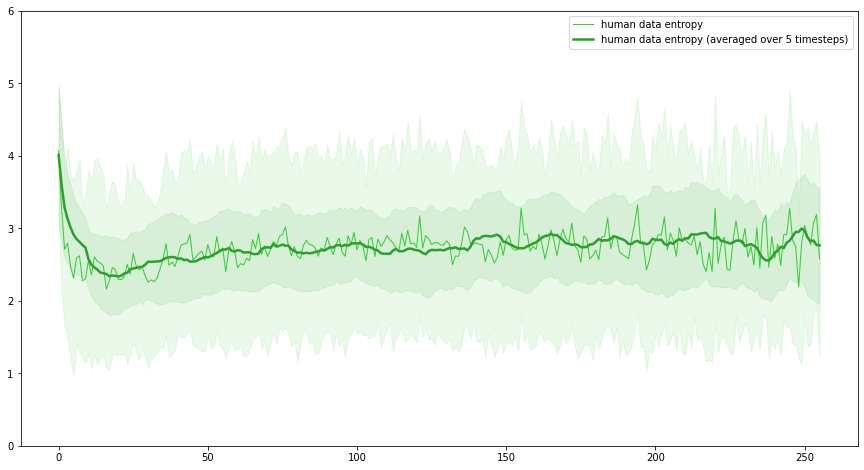

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='limegreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [12]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'human_ma_entropies' is not defined

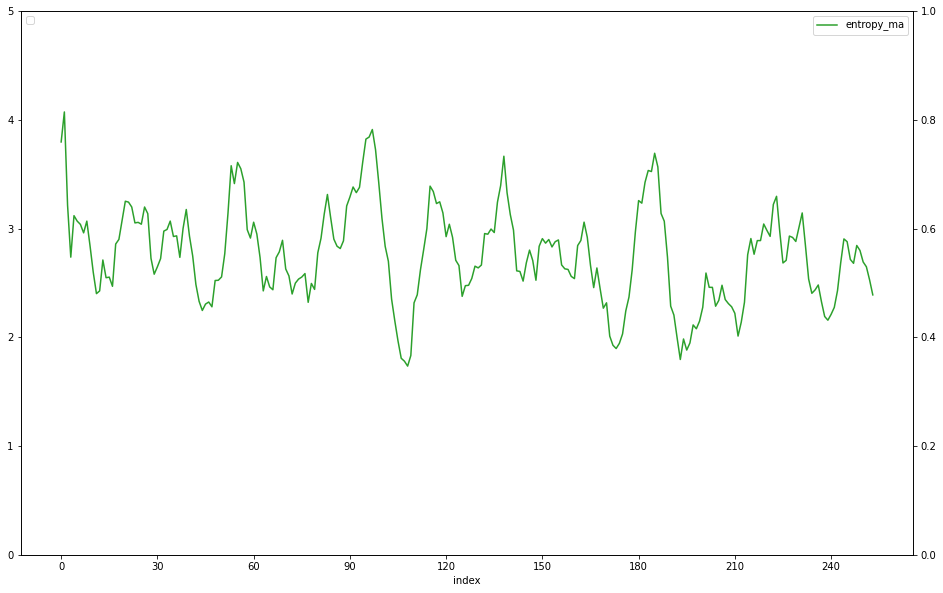

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [14]:
model_greedy_dataframe = pd.read_csv(greedy_generation, sep='\t', names=['context', 'model_text'])

## Examples of various amounts of 3-gram repetition.

In [24]:
human_datapoint = human_dataframe.iloc[100]
# print()
# print(print_sample(human_datapoint.context, human_datapoint.model_text))

human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

In [25]:
print("Context:")
print_sample(human_datapoint.model_text, human_datapoint.context, repeat_type="context")


Context:
an abelian cover is a finite morphism @xmath0 of varieties which is the quotient map for a generically faithful action of a finite abelian group @xmath1 .<newline>this means that for every component @xmath7 of @xmath2 the @xmath1-action on the restricted cover @xmath8 is faithful .<newline>the paper @xcite contains a comprehensive theory of such covers in the case when @xmath2 is smooth and @xmath3 is normal .<newline>the covers are described in terms of the _ building data _ consisting of branch divisors @xmath9 ranging over cyclic subgroups @xmath10 , and line bundles @xmath11 with @xmath12 ranging over the character group of @xmath1 .<newline>this collection must satisfy the _<newline>fundamental relations_.    here , we extend this theory to the case of singular varieties .<newline>namely , we allow @xmath3 and @xmath2 to be varieties satisfying serre s condition @xmath4 and having double crossing singularities in codimension 1 , which we abbreviate to g.d.c . for `` gener

In [26]:

greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
# print("Context:")
# print_sample(human_datapoint.model_text, human_datapoint.context, )


print("Target:")
print_sample(human_datapoint.context, human_datapoint.model_text.replace("\n", "\\n"))
print()
print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "\\n"))
print()

Target:
an abelian cover is a finite morphism @xmath0 of varieties which is the quotient map for a generically faithful action of a finite abelian group @xmath1 . \n abelian covers with @xmath2 smooth and @xmath3 normal were studied in @xcite .    here \n we study the non - normal case , assuming that @xmath3 and @xmath2 are @xmath4 varieties that have at worst normal crossings outside a subset of codimension @xmath5 . \n special attention is paid to the case of @xmath6-covers of surfaces , which is used in @xcite to construct explicitly compactifications of some components of the moduli space of surfaces of general type .

Greedy Model Text: 
an abelian cover is a finite morphism @xmath0 of varieties which is the quotient map for a generically faithful action of a finite abelian group @xmath1. in this paper, we study non - normal abelian covers of singular varieties @xmath2, where @xmath3 and @xmath2 are @xmath4 varieties satisfying serre s condition @xmath4 and having double crossing

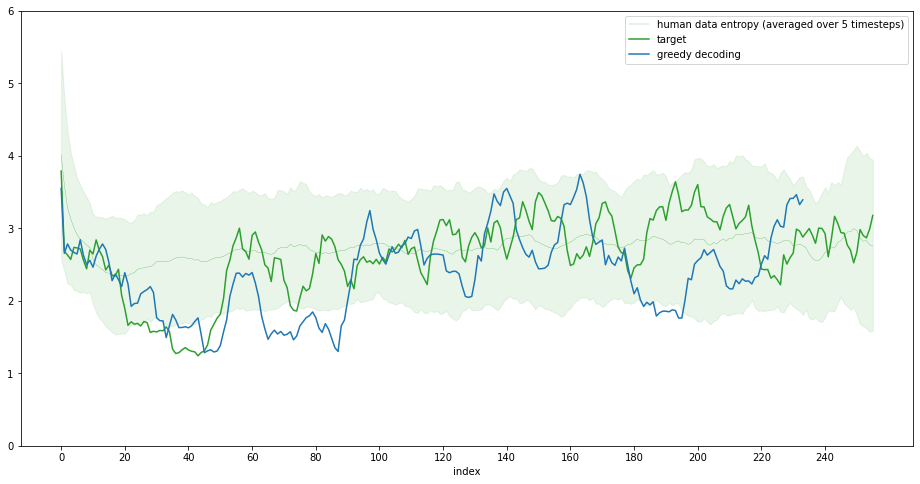

In [205]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

greedy_labeled_datapoint = process_datapoint(
    model=model, datapoint=greedy_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

fig, ax = plt.subplots(figsize=(16, 8))
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.25)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='target', color='tab:green')
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='greedy decoding', color='tab:blue')
# lpdm.plot(x="index", y='dent', ylim=(-4,6), ax=ax)
ax.set_xticks(np.arange(len(lpdh['index']), step=20))

# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Compute Average entropy across timesteps.

### For all model generated data

In [142]:
# Greedy

model_greedy_dataframe = model_greedy_dataframe.dropna()
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy', width=WIDTH,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

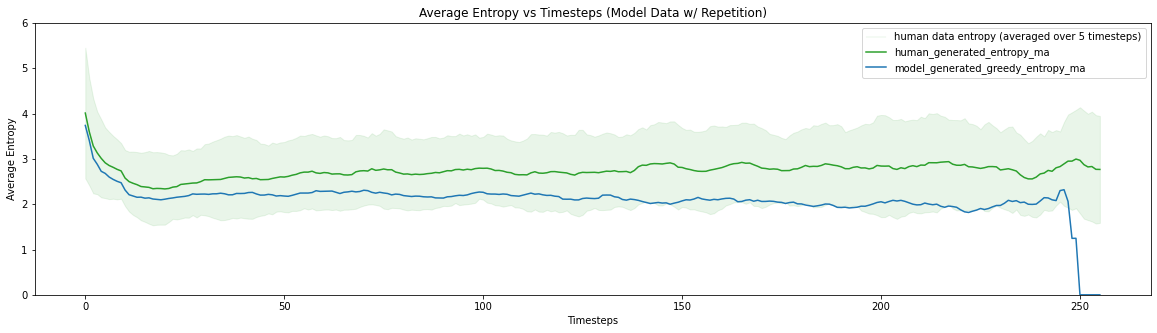

In [107]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps (Model Data w/ Repetition)', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Do errors cascade?

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")